In [1]:
# Uncomment to run the notebook in Colab
# ! pip install -q "wax-ml[complete]@git+https://github.com/eserie/wax-ml.git"
# ! pip install -q --upgrade jax jaxlib==0.1.70+cuda111 -f https://storage.googleapis.com/jax-releases/jax_releases.html

In [2]:
# check available devices
import jax

In [3]:
print("jax backend {}".format(jax.lib.xla_bridge.get_backend().platform))
jax.devices()

jax backend cpu


# 〰 Compute exponential moving averages with xarray and pandas accessors 〰

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eserie/wax-ml/blob/main/docs/notebooks/01_demo_EWMA.ipynb)

WAX-ML implements pandas and xarray accessors to ease the usage of machine-learning algorithms with
high-level data APIs :
- pandas's `DataFrame` and `Series`
- xarray's `Dataset` and `DataArray`.

These accessors allow to easily execute any function using Haiku modules
on these data containers.

For instance, WAX-ML propose an implementation of the exponential moving average realized
with this mechanism.

Let's show how it works.

## Load accessors

First you need to load accessors:

In [4]:
from wax.accessors import register_wax_accessors

register_wax_accessors()

## EWMA on dataframes

Let's look at a simple example: The exponential moving average (EWMA).

Let's apply the EWMA algorithm to the [NCEP/NCAR 's Air temperature data](http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.html).

### 🌡 Load temperature dataset 🌡

In [5]:
import xarray as xr

dataset = xr.tutorial.open_dataset("air_temperature")

Let's see what this dataset looks like:

In [6]:
dataset

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

To compute a EWMA on some variables of a dataset, we usually need to convert data
in pandas
[series](https://pandas.pydata.org/docs/reference/api/pandas.Series.html) or
[dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).

So, let's convert the dataset into a dataframe to illustrate `accessors` on a dataframe:

In [7]:
dataframe = dataset.air.to_series().unstack(["lon", "lat"])

### EWMA with pandas

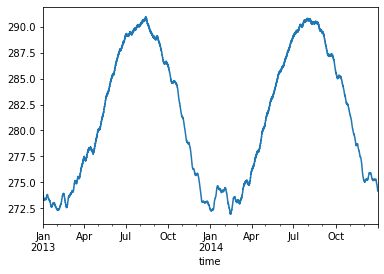

In [8]:
air_temp_ewma = dataframe.ewm(com=10).mean()
_ = air_temp_ewma.mean(1).plot()

### EWMA with WAX-ML

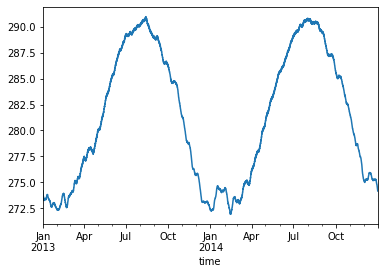

In [11]:
air_temp_ewma = dataframe.wax.ewm(com=10).mean()
_ = air_temp_ewma.mean(1).plot()

On small data, WAX-ML's EWMA is slower than Pandas' because of the expensive data conversion steps.
WAX-ML's accessors are interesting to use on large data loads
(See our [three-steps_workflow](https://wax-ml.readthedocs.io/en/latest/notebooks/04_The_three_steps_workflow.html))

## Apply a custom function to a Dataset

Now let's illustrate how WAX-ML accessors work on [xarray datasets](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.html).

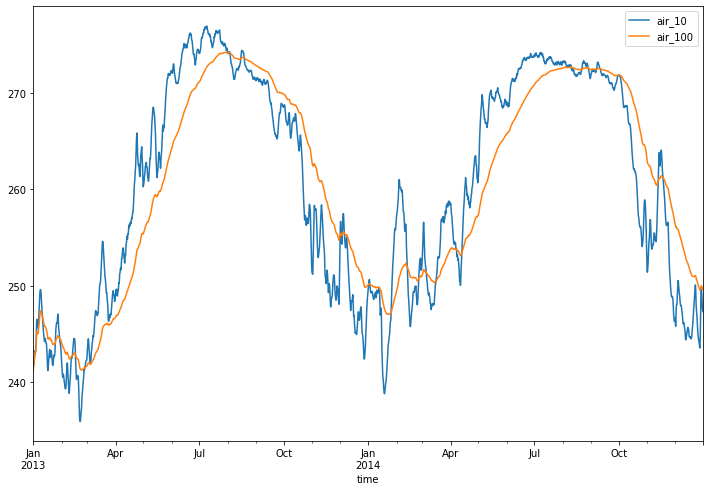

In [12]:
from wax.modules import EWMA


def my_custom_function(dataset):
    return {
        "air_10": EWMA(com=10)(dataset["air"]),
        "air_100": EWMA(com=100)(dataset["air"]),
    }


dataset = xr.tutorial.open_dataset("air_temperature")
output, state = dataset.wax.stream().apply(
    my_custom_function, format_dims=dataset.air.dims
)

_ = output.isel(lat=0, lon=0).drop(["lat", "lon"]).to_dataframe().plot(figsize=(12, 8))